# **Prediksi Nilai NO2 Satu Hari Kedepan dengan KNN Regression**

**Tujuan**: Memprediksi nilai NO₂ satu hari ke depan menggunakan KNN Regression, lalu menerapkan threshold untuk klasifikasi status

**Lokasi** Mencangkup :
- Kota Surabaya
- Sebagian wilayah Kabupaten Sidoarjo
- Sebagian Kabupaten Gresik

**Data Source**: Sentinel-5P (Copernicus Data Space)

**Metode**:
- KNN Regression untuk prediksi nilai kontinyu
- Threshold Application untuk klasifikasi (Aman/Berbahaya)

**Periode**:
- During COVID: **2020-06-01 s.d. 2021-06-30**
- Post COVID: **2022-06-01 s.d. 2023-06-30**

## **1. Mengumpulkan data dan dijadikan CSV**

In [3]:
import openeo
import xarray as xr
import matplotlib.pyplot as plt

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

spatial_extent = {
    "west": 112.5,
    "south": -7.45,
    "east": 112.95,
    "north": -7.05
}

# During COVID
s5covid = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2020-06-01", "2021-06-30"],
    spatial_extent=spatial_extent,
    bands=["NO2"], 
).aggregate_temporal_period(reducer="mean", period="day")

# Post COVID
s5post = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2022-06-01", "2023-06-30"],
    spatial_extent=spatial_extent,
    bands=["NO2"],  
).aggregate_temporal_period(reducer="mean", period="day")

job_covid = s5covid.execute_batch(title="NO2 during Covid", outputfile="during_covid.nc")
job_post = s5post.execute_batch(title="NO2 Post-Covid", outputfile="post_covid.nc")

Authenticated using refresh token.
0:00:00 Job 'j-25102415254144aaa53e7143b5cdf76c': send 'start'
0:00:14 Job 'j-25102415254144aaa53e7143b5cdf76c': created (progress 0%)
0:00:19 Job 'j-25102415254144aaa53e7143b5cdf76c': created (progress 0%)
0:00:26 Job 'j-25102415254144aaa53e7143b5cdf76c': created (progress 0%)
0:00:34 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:00:44 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:00:57 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:01:13 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:01:32 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:01:56 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:02:27 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:03:06 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:03:53 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:04:52 Job 'j-25102415254144

In [5]:
# --- DOWNLOAD HASIL DARI SERVER ---
results_covid = job_covid.get_results()
results_post = job_post.get_results()

results_covid.download_files(target="results_covid")
results_post.download_files(target="results_post")

# --- KONVERSI KE CSV ---
import xarray as xr
import pandas as pd

# Load data dari NetCDF
during = xr.open_dataset("during_covid.nc")
post = xr.open_dataset("post_covid.nc")

# Ambil rata-rata spasial (x dan y) biar jadi satu nilai NO2 per waktu
during_mean = during.NO2.mean(dim=["x", "y"]).to_dataframe().reset_index()
post_mean = post.NO2.mean(dim=["x", "y"]).to_dataframe().reset_index()

# Simpan hasil ke CSV
during_mean.to_csv("no2_during_covid.csv", index=False)
post_mean.to_csv("no2_post_covid.csv", index=False)

print("✅ Data berhasil disimpan sebagai CSV:")
print("- no2_during_covid.csv")
print("- no2_post_covid.csv")

✅ Data berhasil disimpan sebagai CSV:
- no2_during_covid.csv
- no2_post_covid.csv


## **2. Memprosessing data jika ada missing values  dengan interpolasi**
Mengisi missing values dengan interpolasi waktu (time-based interpolation) agar datanya tetap konsisten untuk analisis.

In [9]:
import pandas as pd

# Load data hasil tahap 1
during_mean = pd.read_csv("no2_during_covid.csv")
post_mean = pd.read_csv("no2_post_covid.csv")

print("📊 HASIL PEMROSESAN DATA NO₂\n")

# 🔍 Cek missing values sebelum interpolasi
missing_during_before = during_mean.isna().sum()
missing_post_before = post_mean.isna().sum()

print("🔍 Missing Values Sebelum Interpolasi:")
print(f"- During COVID:\n{missing_during_before}")
print(f"- Post COVID:\n{missing_post_before}\n")

# --- Pastikan kolom waktu dikenali sebagai datetime dan dijadikan index ---
for df in [during_mean, post_mean]:
    if 't' in df.columns:  # kalau nama kolom waktu 't'
        df.rename(columns={'t': 'time'}, inplace=True)
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    df.sort_index(inplace=True)

# --- Interpolasi time-based ---
during_mean_interpolated = during_mean.interpolate(method='time')
post_mean_interpolated = post_mean.interpolate(method='time')

# Cek hasil interpolasi
missing_during_after = during_mean_interpolated.isna().sum()
missing_post_after = post_mean_interpolated.isna().sum()

print("✅ Missing Values Setelah Interpolasi:")
print(f"- During COVID:\n{missing_during_after}")
print(f"- Post COVID:\n{missing_post_after}\n")

#  Simpan hasil interpolasi ke CSV baru
during_mean_interpolated.reset_index().to_csv("no2_during_covid_clean.csv", index=False)
post_mean_interpolated.reset_index().to_csv("no2_post_covid_clean.csv", index=False)

print("💾 Data bersih sudah disimpan sebagai:")
print("- no2_during_covid_clean.csv")
print("- no2_post_covid_clean.csv\n")

# --- Buat ringkasan tabel hasil pembersihan data ---
summary = pd.DataFrame({
    "Dataset": ["During COVID", "Post COVID"],
    "Missing Sebelum": [missing_during_before['NO2'], missing_post_before['NO2']],
    "Missing Setelah": [missing_during_after['NO2'], missing_post_after['NO2']],
})

print("📋 Ringkasan Proses Interpolasi:\n")
display(summary)


📊 HASIL PEMROSESAN DATA NO₂

🔍 Missing Values Sebelum Interpolasi:
- During COVID:
t       0
NO2    78
dtype: int64
- Post COVID:
t       0
NO2    85
dtype: int64

✅ Missing Values Setelah Interpolasi:
- During COVID:
NO2    2
dtype: int64
- Post COVID:
NO2    0
dtype: int64

💾 Data bersih sudah disimpan sebagai:
- no2_during_covid_clean.csv
- no2_post_covid_clean.csv

📋 Ringkasan Proses Interpolasi:



,Dataset,Missing Sebelum,Missing Setelah
0,During COVID,78,2
1,Post COVID,85,0


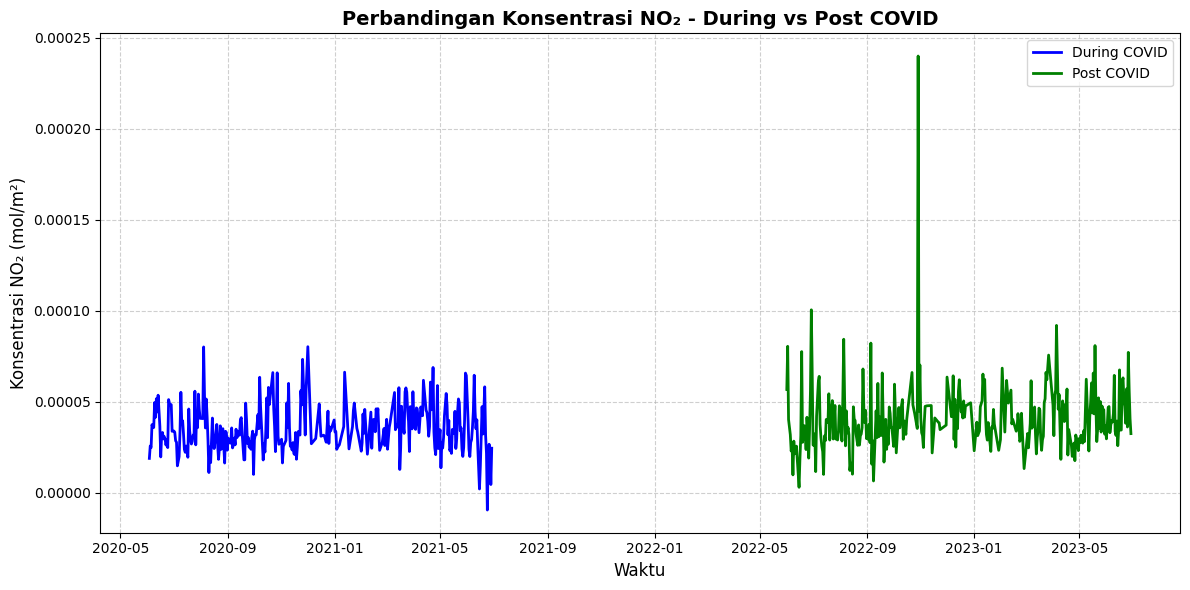

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load data bersih ---
during = pd.read_csv("no2_during_covid_clean.csv")
post = pd.read_csv("no2_post_covid_clean.csv")

# Pastikan kolom waktu terdeteksi sebagai datetime
during['time'] = pd.to_datetime(during['time'])
post['time'] = pd.to_datetime(post['time'])

# --- Buat plot ---
plt.figure(figsize=(12, 6))
plt.plot(during['time'], during['NO2'], label='During COVID', color='blue', linewidth=2)
plt.plot(post['time'], post['NO2'], label='Post COVID', color='green', linewidth=2)

# --- Tambahan estetika ---
plt.title('Perbandingan Konsentrasi NO₂ - During vs Post COVID', fontsize=14, weight='bold')
plt.xlabel('Waktu', fontsize=12)
plt.ylabel('Konsentrasi NO₂ (mol/m²)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# --- Tampilkan plot ---
plt.show()


### **Penjelasan:** 
**Perbandingan Konsentrasi NO₂ - During vs Post COVID**
- **Sumbu-X (horizontal)**: Waktu pengamatan (dalam rentang tanggal).
- **Sumbu-Y (vertikal)**: Konsentrasi NO₂ (Nitrogen Dioksida) dalam satuan mol/m².

 **Periode During COVID (garis biru) :**
- Terlihat relatif stabil dengan sedikit fluktuasi di kisaran 0.00003–0.00007 mol/m².
- Tidak ada lonjakan besar — ini menunjukkan bahwa selama pandemi (saat mobilitas menurun), polusi NO₂ cenderung rendah dan terkendali.
- Hal ini sesuai dengan banyak penelitian yang menemukan penurunan emisi akibat pembatasan aktivitas industri dan transportasi.

 **Periode Post COVID (garis hijau) :**
- Secara umum, tingkat NO₂ meningkat sedikit dibanding masa pandemi.
- Ada satu lonjakan signifikan sekitar pertengahan 2022, kemungkinan besar akibat aktivitas industri/transportasi yang kembali normal.
- Setelah lonjakan itu, pola NO₂ cenderung lebih fluktuatif, menunjukkan aktivitas ekonomi yang sudah pulih.

 **Kesimpulan dari Grafik :**
- Secara visual, **selama pandemi** terjadi **penurunan konsentrasi NO₂** yang cukup konsisten.
- **Setelah pandemi**, terjadi **kenaikan dan variabilitas lebih besar**. Artinya aktivitas emisi kembali meningkat.
- Grafik ini mendukung analisis dampak kebijakan pembatasan sosial terhadap kualitas udara.

## **3. Membentuk Data Supervised**
Mengubah data deret waktu (time series) menjadi data supervised learning, yaitu dengan membuat pasangan:
- Input (X): nilai NO₂ pada waktu sebelumnya
- Target (y): nilai NO₂ pada waktu berikutnya

In [14]:
import pandas as pd

# --- Load data bersih hasil interpolasi ---
during_clean = pd.read_csv("no2_during_covid_clean.csv")
post_clean = pd.read_csv("no2_post_covid_clean.csv")

# Pastikan kolom waktu diubah jadi datetime
during_clean['time'] = pd.to_datetime(during_clean['time'])
post_clean['time'] = pd.to_datetime(post_clean['time'])

# --- Fungsi bantu untuk ubah time series ke supervised ---
def make_supervised(df, target_col='NO2', lag=1):
    data = pd.DataFrame()
    for i in range(1, lag + 1):
        data[f'{target_col}_lag{i}'] = df[target_col].shift(i)
    data[target_col] = df[target_col]
    data = data.dropna().reset_index(drop=True)
    return data

# Ubah data menjadi format supervised dengan 1 lag (bisa diganti ke 2–3 lag kalau mau)
during_supervised = make_supervised(during_clean)
post_supervised = make_supervised(post_clean)

# --- Simpan hasil ke CSV ---
during_supervised.to_csv("no2_during_covid_supervised.csv", index=False)
post_supervised.to_csv("no2_post_covid_supervised.csv", index=False)

print("✅ Data supervised berhasil dibuat dan disimpan:")
print("- no2_during_covid_supervised.csv")
print("- no2_post_covid_supervised.csv")

# --- Tampilkan contoh data ---
print("\n📋 Contoh data supervised (During COVID):")
display(during_supervised.head())



✅ Data supervised berhasil dibuat dan disimpan:
- no2_during_covid_supervised.csv
- no2_post_covid_supervised.csv

📋 Contoh data supervised (During COVID):


,NO2_lag1,NO2
0,0.000019,0.000026
1,0.000026,0.000025
2,0.000025,0.000037
3,0.000037,0.000036
4,0.000036,0.000036


### **Penjelasan :**
- Kolom NO2_lag1 → nilai NO₂ pada waktu sebelumnya (t-1)
- Kolom NO2 → nilai NO₂ pada waktu sekarang (t)
- Setiap baris menunjukkan pasangan data yang bisa digunakan untuk prediksi deret waktu (time series) — misalnya memprediksi kadar NO₂ berdasarkan data sebelumnya.

## **4. Melakukan normalisai data (min-max atau zscore (standar scale di sklearn))**
- Min-Max Scaling: ubah data ke rentang [0, 1]

In [19]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# --- Load data supervised hasil langkah 3 ---
df_supervised = pd.read_csv("no2_during_covid_supervised.csv")  # atau post_covid_supervised.csv

# Pisahkan fitur (X) dan target (y)
X = df_supervised[['NO2_lag1']]
y = df_supervised[['NO2']]

# --- Normalisasi dengan Min-Max (pakai dua scaler terpisah) ---
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Gabungkan hasil ke DataFrame baru
df_scaled = pd.DataFrame({
    'NO2_lag1_scaled': X_scaled.flatten(),
    'NO2_scaled': y_scaled.flatten()
})

# Simpan ke file CSV
df_scaled.to_csv("no2_during_covid_supervised_scaled.csv", index=False)

print("✅ Normalisasi selesai dan disimpan sebagai 'no2_during_covid_supervised_scaled.csv'")
display(df_scaled.head())


✅ Normalisasi selesai dan disimpan sebagai 'no2_during_covid_supervised_scaled.csv'


,NO2_lag1_scaled,NO2_scaled
0,0.316152,0.392084
1,0.392084,0.382544
2,0.382544,0.522623
3,0.522623,0.505241
4,0.505241,0.505399


### **Penjelasan :**
- Semua nilai berada pada rentang 0–1, artinya proses scaling berhasil.
- Tidak ada nilai di luar rentang (negatif atau lebih dari 1), jadi tidak terjadi error atau outlier setelah normalisasi.
- Kolom NO2_lag1_scaled akan digunakan sebagai fitur input (X), sedangkan
NO2_scaled sebagai target output (y).

## **5. Membuat model dengan K-NN regression**
- Melakukan experiment dengan beberapa fitur (menentukan berapa lag data : berkaitan dengan no 3)



🔹 Eksperimen dengan lag = 1
📉 MSE: 0.022075
📈 R²: 0.1866


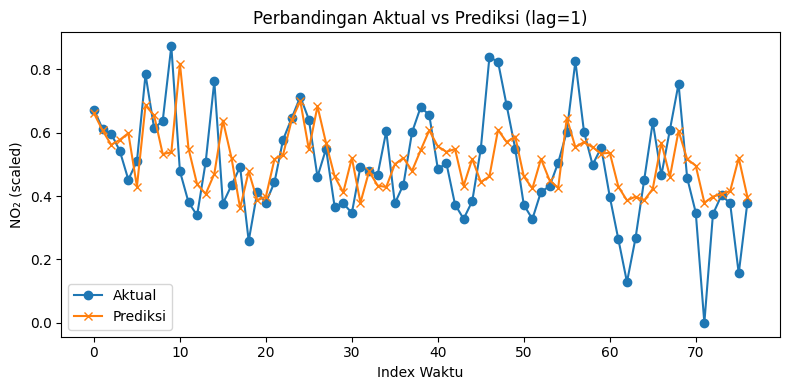


🔹 Eksperimen dengan lag = 2
📉 MSE: 0.020924
📈 R²: 0.2290


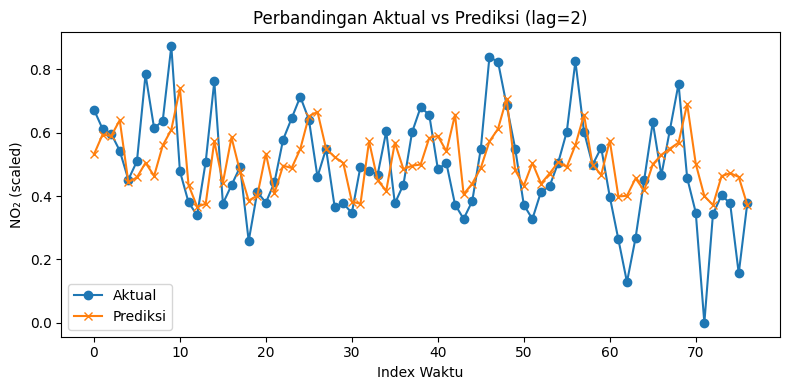


🔹 Eksperimen dengan lag = 3
📉 MSE: 0.020415
📈 R²: 0.2478


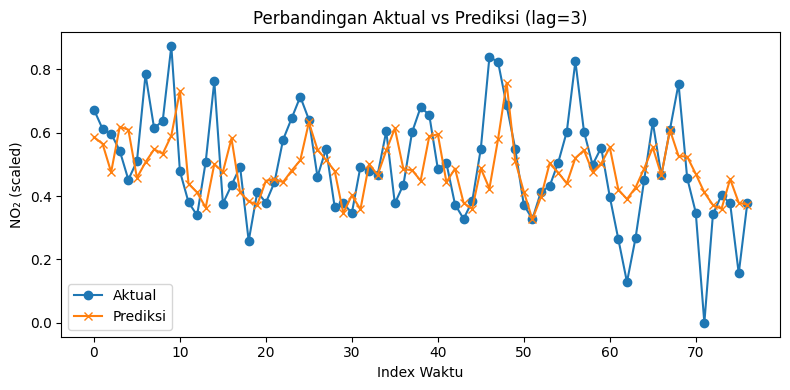

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# --- Load data supervised hasil normalisasi ---
df = pd.read_csv("no2_during_covid_supervised_scaled.csv")

# --- Eksperimen dengan beberapa jumlah lag ---
for lag in [1, 2, 3]:
    print(f"\n🔹 Eksperimen dengan lag = {lag}")

    # Buat ulang data supervised sesuai jumlah lag
    def make_supervised(df, target_col='NO2_scaled', lag=lag):
        data = pd.DataFrame()
        for i in range(1, lag + 1):
            data[f'{target_col}_lag{i}'] = df[target_col].shift(i)
        data[target_col] = df[target_col]
        data = data.dropna().reset_index(drop=True)
        return data

    df_supervised = make_supervised(df)
    X = df_supervised.drop(columns=['NO2_scaled'])
    y = df_supervised['NO2_scaled']

    # --- Split data: 80% train, 20% test ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=False
    )

    # --- Inisialisasi dan training model KNN ---
    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(X_train, y_train)

    # --- Prediksi dan evaluasi ---
    y_pred = knn.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"📉 MSE: {mse:.6f}")
    print(f"📈 R²: {r2:.4f}")

    # --- Visualisasi hasil prediksi vs aktual ---
    plt.figure(figsize=(8,4))
    plt.plot(y_test.values, label='Aktual', marker='o')
    plt.plot(y_pred, label='Prediksi', marker='x')
    plt.title(f'Perbandingan Aktual vs Prediksi (lag={lag})')
    plt.xlabel('Index Waktu')
    plt.ylabel('NO₂ (scaled)')
    plt.legend()
    plt.tight_layout()
    plt.show()


### **Penjelasan Langkah :**

1. **Eksperimen Lag**
3 variasi lag (lag=1,2,3).
- Lag 1 = model hanya lihat nilai NO₂ sehari sebelumnya
- Lag 2/3 = model lihat 2–3 hari sebelumnya untuk memprediksi nilai saat ini

2. **Split Data**
- Data dibagi menjadi 80% training dan 20% testing
- shuffle=False karena ini data time series (urutan waktu harus dijaga)

3. **Model**
- Menggunakan KNeighborsRegressor(n_neighbors=3)
artinya prediksi didasarkan pada rata-rata dari 3 titik data terdekat

4. **Evaluasi**
- MSE (Mean Squared Error) → seberapa besar kesalahan prediksi
- R² (R-squared) → seberapa baik model menjelaskan variasi data
(semakin mendekati 1, semakin bagus)

5. **Visualisasi**
- Grafik menunjukkan perbandingan antara nilai aktual dan hasil prediksi
- Pola yang mirip menunjukkan model mampu menangkap tren data dengan baik

### **Hasil :**

1. **Lag = 1**
- MSE = 0.0221
Artinya, rata-rata selisih kuadrat antara hasil prediksi dan data asli masih cukup tinggi.

- R² = 0.1866
Artinya model hanya bisa menjelaskan sekitar 18,6% variasi data aktual.
Dengan kata lain, model ini belum terlalu baik karena hanya melihat 1 data sebelumnya (lag 1) untuk memprediksi data berikutnya.

2. **Lag = 2**
- MSE = 0.0209 (lebih kecil dari sebelumnya)
- R² = 0.2290 (meningkat jadi sekitar 22,9%)

3. **Lag = 3**
- MSE = 0.0204
- R² = 0.2478
Artinya model dengan lag=3 memiliki performa terbaik di antara tiga percobaan.

**Kesimpulan Umum**
- Menambah jumlah lag (dari 1 ke 3) meningkatkan akurasi model.
- Namun peningkatannya masih kecil, sehingga data ini mungkin butuh fitur tambahan (seperti suhu, kecepatan angin, atau hari keberapa dalam minggu) agar prediksi lebih akurat.
- Nilai R² < 0.3 menunjukkan model masih belum cukup baik, tapi arah perbaikan sudah terlihat jelas.